In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch_geometric.transforms as T

from torch_geometric.nn import MessagePassing
from torch_geometric.datasets import Planetoid, WebKB
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class SheafDiffusion(MessagePassing):
    def __init__(self, in_channels):
        super(SheafDiffusion, self).__init__(aggr='add')
        self.V = nn.Linear(2*in_channels, in_channels**2)
        self.act = nn.ELU()

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        t1 = self.V(torch.cat([x_i, x_j], dim=1))
        #t1 = t1.reshape(t1.shape[1], t1.shape[0])
        t1 = self.act(t1).T
        t2 = self.V(torch.cat([x_j, x_i], dim=1))
        #t2 = t2.reshape(t2.shape[1], t2.shape[0])
        t2 = self.act(t2).T
        return torch.matmul(t1.T , t1 @ x_i - t2 @ x_j)

    def update(self, aggr_out):
        return aggr_out

In [4]:
class NodeClassifier(nn.Module):
    def __init__(self, in_channels, stalk_dim, num_classes):
        super(NodeClassifier, self).__init__()
        self.lin1 = nn.Linear(in_channels, stalk_dim)
        self.diffusion = SheafDiffusion(stalk_dim)
        self.classifier = nn.Linear(stalk_dim, num_classes)
    
    def remove_edge_duplications(self, edge_index):
        edges = list(zip(edge_index[0], edge_index[1]))

        unique_pairs = set(tuple(sorted(map(int, pair))) for pair in edges)
        sorted_unique_pairs = sorted(unique_pairs, key=lambda x: x[0])

        result_list = [tuple(map(torch.tensor, pair)) for pair in sorted_unique_pairs]
        result_list = torch.tensor(result_list)
        return result_list.T

    def forward(self, x, edge_index, device):
        edges = self.remove_edge_duplications(edge_index)
        edges = edges.to(device)

        x = self.lin1(x)
        x = self.diffusion(x, edges)
        x = self.classifier(x)
        return x

In [5]:
Cora = Planetoid(root='/tmp/Cora', name='Cora', split='full')[0]
CiteSeer = Planetoid(root='/tmp/CiteSeer', name='CiteSeer', split='full')[0]
PubMed = Planetoid(root='/tmp/PubMed', name='PubMed', split='full')[0]

In [6]:
Texas = WebKB(root='/tmp/WebKB', name='Texas')[0]
Wisconsin = WebKB(root='/tmp/WebKB', name='Wisconsin')[0]
Cornell = WebKB(root='/tmp/WebKB', name='Cornell')[0]

In [7]:
def train(data, stalk_dim, device, epochs=1000):
    X = data.x
    y = data.y
    _, f = X.shape
    d = stalk_dim
    n_classes = y.unique().shape[0]

    train_mask = data.train_mask
    val_mask = data.val_mask
    test_mask = data.test_mask
    edge_index = data.edge_index.to(device)

    if len(train_mask.shape) == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    model = NodeClassifier(f, d, n_classes).to(device)
    X = X.to(device)
    y = y.to(device)
    train_mask = train_mask.to(device)
    test_mask = test_mask.to(device)
    val_mask = val_mask.to(device)
    optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, min_lr=1e-6, patience=100)

    loss = nn.CrossEntropyLoss()
    #loss = F.nll_loss

    val_accuracies, test_accuracies = [], []

    patience = 10
    best_epoch = 0

    for epoch in range(1, epochs+1):
        # train
        optimizer.zero_grad()
        yh = model(X, edge_index, device)
        l = loss(yh[train_mask], y[train_mask])
        l.backward()
        optimizer.step()
        
        
        yval = torch.argmax(yh[val_mask], dim=1)
        ytest = torch.argmax(yh[test_mask], dim=1)
        ytrain = torch.argmax(yh[train_mask], dim=1)
        
        val_acc = (yval == y[val_mask]).float().mean().item()
        test_acc = (ytest == y[test_mask]).float().mean().item()
        train_acc = (ytrain == y[train_mask]).float().mean().item()
        
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)
        print(l.detach())
        print('Epoch ' + str(epoch) + ' train: ' + str(train_acc) + ' val: ' + str(val_acc) + ' test: ' + str(test_acc) )
        
        scheduler.step(val_acc)

        if epoch > 2 and val_accuracies[-1] <= val_accuracies[-2-epochs_no_improve]:
            epochs_no_improve = epochs_no_improve + 1
        else:
            epochs_no_improve = 0
            best_epoch = epoch
            best_model = model.state_dict()

        if epochs_no_improve >= patience:
            print(f'Early stopping! Best epoch: {best_epoch}')
            break

    plt.plot(val_accuracies, label='val')
    plt.plot(test_accuracies, label='test')
    plt.legend()
    plt.show()

    return best_model

tensor(4.8907)
Epoch 1 train: 0.2068965584039688 val: 0.22033898532390594 test: 0.13513512909412384
tensor(564.2535)
Epoch 2 train: 0.09195402264595032 val: 0.22033898532390594 test: 0.10810811072587967
tensor(737.3758)
Epoch 3 train: 0.26436781883239746 val: 0.35593220591545105 test: 0.45945945382118225
tensor(347.4505)
Epoch 4 train: 0.4252873659133911 val: 0.4406779706478119 test: 0.45945945382118225
tensor(156.1743)
Epoch 5 train: 0.19540229439735413 val: 0.22033898532390594 test: 0.18918919563293457


tensor(148.4523)
Epoch 6 train: 0.2298850566148758 val: 0.2881355881690979 test: 0.18918919563293457
tensor(116.6791)
Epoch 7 train: 0.3448275923728943 val: 0.2542372941970825 test: 0.3243243098258972
tensor(74.4463)
Epoch 8 train: 0.3218390941619873 val: 0.23728813230991364 test: 0.29729729890823364
tensor(185.0547)
Epoch 9 train: 0.28735631704330444 val: 0.3050847351551056 test: 0.3513513505458832
tensor(343.5993)
Epoch 10 train: 0.37931033968925476 val: 0.3050847351551056 test: 0.3513513505458832
tensor(263.5193)
Epoch 11 train: 0.37931033968925476 val: 0.35593220591545105 test: 0.3243243098258972
tensor(105.9521)
Epoch 12 train: 0.40229883790016174 val: 0.4067796468734741 test: 0.3513513505458832
tensor(52.8998)
Epoch 13 train: 0.5632184147834778 val: 0.508474588394165 test: 0.4864864945411682
tensor(71.4653)
Epoch 14 train: 0.6091954112052917 val: 0.5254237055778503 test: 0.5675675868988037
tensor(48.0466)
Epoch 15 train: 0.6206896305084229 val: 0.5254237055778503 test: 0.56756758

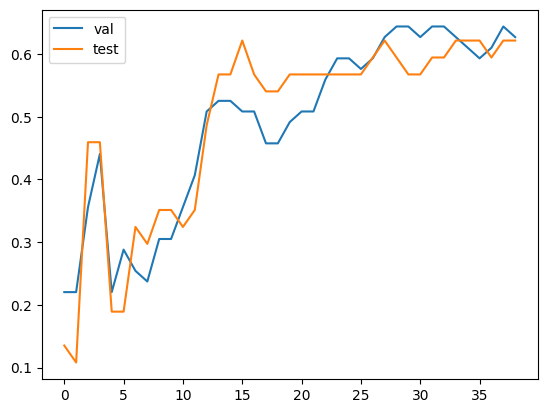

In [8]:
cora_best_model = train(Texas, 10, device, epochs=1000)

tensor(60.3859)
Epoch 1 train: 0.14166666567325592 val: 0.08749999850988388 test: 0.13725490868091583
tensor(17579.7910)
Epoch 2 train: 0.18333333730697632 val: 0.1875 test: 0.1764705926179886
tensor(26097.9629)
Epoch 3 train: 0.30000001192092896 val: 0.32499998807907104 test: 0.45098039507865906
tensor(6019.3311)
Epoch 4 train: 0.24166665971279144 val: 0.32499998807907104 test: 0.37254902720451355
tensor(8790.8193)
Epoch 5 train: 0.10000000149011612 val: 0.10000000149011612 test: 0.0784313753247261
tensor(2462.2812)
Epoch 6 train: 0.3333333432674408 val: 0.26249998807907104 test: 0.23529411852359772
tensor(3743.2964)
Epoch 7 train: 0.36666667461395264 val: 0.3375000059604645 test: 0.529411792755127
tensor(5292.9614)
Epoch 8 train: 0.34166666865348816 val: 0.26249998807907104 test: 0.21568627655506134
tensor(2910.1272)
Epoch 9 train: 0.375 val: 0.36250001192092896 test: 0.2549019753932953
tensor(4354.1377)
Epoch 10 train: 0.4749999940395355 val: 0.4124999940395355 test: 0.5686274766921

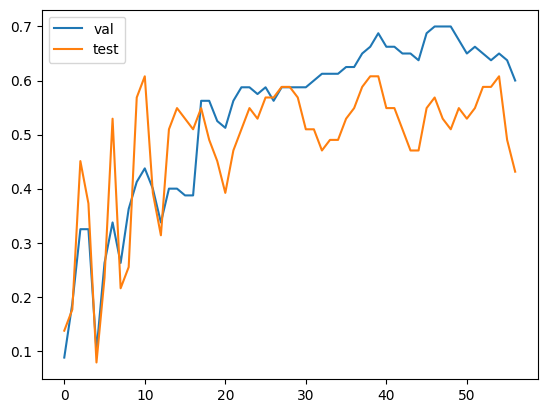

In [9]:
wisconsin_best_model = train(Wisconsin, 39, device, epochs=1000)